# Create instances of Data from Gaussian mocks

In [1]:
import time

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction
from mockfactory import EulerianLinearMock, LagrangianLinearMock, RandomBoxCatalog, setup_logging

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import generate_mock, split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func_utils import *

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog_dat = catalog_data.Data.load(data_dir+catalog_name+'.npy')

cellsize = 10
resampler = 'tsc'

# Compute density with weights
catalog = density_split.DensitySplit(catalog_dat)
catalog.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

[000001.90] [0/1] 06-09 12:40  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2934922.
[000002.70] [0/1] 06-09 12:40  CatalogMesh               INFO     Painted 2934922 out of 2934922 objects to mesh.


## Mock properties

In [4]:
nmesh = 100
boxsize = catalog.boxsize
boxcenter = catalog.boxcenter
seed = 42
los = 'x'
nbar = 5*catalog.data.size/catalog.boxsize**3

z = catalog.data.redshift

# Abacus summit cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

f = bg.growth_rate(z)
bias = 1.8

pklin = cosmo_abacus.get_fourier().pk_interpolator().to_1d(z)

In [5]:
nbar

0.01467461

## Abacus summit cosmology

In [6]:
# unitary_amplitude forces amplitude to 1
mock = EulerianLinearMock(pklin, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=seed, unitary_amplitude=False)

mock.set_real_delta_field(bias=bias)

data = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=seed)
data['Weight'] = mock.readout(data['Position'], field='delta', resampler='tsc', compensate=True) + 1.

[000003.81] [0/1] 06-09 12:40  EulerianLinearMock        INFO     White noise generated.


In [7]:
# Create Data instance
positions = data['Position'].T % boxsize

# Set rsd
mock.set_rsd(f=f, los=los)
data_rsd = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=seed)
data_rsd['Weight'] = mock.readout(data_rsd['Position'], field='delta', resampler='tsc', compensate=True) + 1.

positions_rsd = data_rsd['Position'].T % boxsize

mock_catalog = catalog_data.Data(positions, z, boxsize, boxcenter, name='mock', weights=data['Weight'])
mock_catalog.set_rsd(positions_rsd=positions_rsd)

mock_catalog.save(output_dir+catalog_name+'_gaussianMock_nbarx5')

## Compute density

In [8]:
cellsize = 10
resampler = 'tsc'

# Compute density without weights
mock_density = density_split.DensitySplit(mock_catalog)
mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

[000032.13] [0/1] 06-09 12:41  CatalogMesh               INFO     Slab 0 ~ 4194304 / 14674610.
[000033.65] [0/1] 06-09 12:41  CatalogMesh               INFO     Painted 4194304 out of 14674610 objects to mesh.
[000033.66] [0/1] 06-09 12:41  CatalogMesh               INFO     Slab 4194304 ~ 8388608 / 14674610.
[000035.13] [0/1] 06-09 12:41  CatalogMesh               INFO     Painted 8388608 out of 14674610 objects to mesh.
[000035.13] [0/1] 06-09 12:41  CatalogMesh               INFO     Slab 8388608 ~ 12582912 / 14674610.
[000036.61] [0/1] 06-09 12:41  CatalogMesh               INFO     Painted 12582912 out of 14674610 objects to mesh.
[000036.61] [0/1] 06-09 12:41  CatalogMesh               INFO     Slab 12582912 ~ 16777216 / 14674610.
[000037.35] [0/1] 06-09 12:41  CatalogMesh               INFO     Painted 14674610 out of 14674610 objects to mesh.


### Plot density distribution

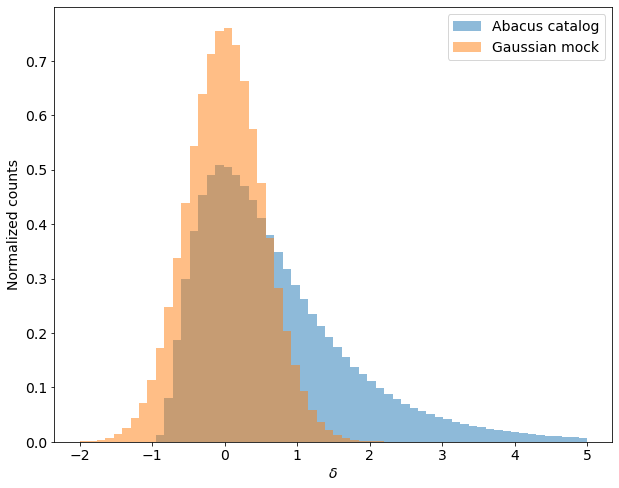

In [9]:
plt.hist(catalog.data_densities, range=(-2, 5), bins=60, density=True, alpha=0.5, label='Abacus catalog')
plt.hist(mock_density.data_densities, range=(-2, 5), bins=60, density=True, alpha=0.5, label='Gaussian mock')
#plt.hist(np.array(catalog.density_mesh).flatten(), range=(-2, 5), bins=60, density=True, alpha=0.5, label='Abacus catalog')
#plt.hist(np.array(mock_density.density_mesh).flatten(), range=(-2, 5), bins=60, density=True, alpha=0.5, label='Gaussian mock')
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.legend()
plt.show()

## Compute 2PCF

In [9]:
edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))
los = 'x'

In [20]:
result = TwoPointCorrelationFunction('smu', edges,
                                     data_positions1=mock_catalog.positions, data_weights1=mock_catalog.weights,
                                     boxsize=mock_catalog.boxsize,
                                     engine='corrfunc', nthreads=128,
                                     los = los)

[000112.66] [0/1] 06-02 12:08  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000112.66] [0/1] 06-02 12:08  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000156.07] [0/1] 06-02 12:09  TwoPointCorrelationFunction INFO     Analytically computing two-point counts R1R2.


## Compare mock 2PCF with data

In [21]:
ells = [0]
nells = len(ells)

In [22]:
abacus_results = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_2Gpc_z1.175_2PCF.npy')

[000156.07] [0/1] 06-02 12:09  TwoPointEstimator         INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z1.175_2PCF.npy.


In [23]:
s, abacus_xiell = abacus_results.get_corr(ells=ells, return_sep=True)
mocks_xiell = result.get_corr(ells=ells, return_sep=False)

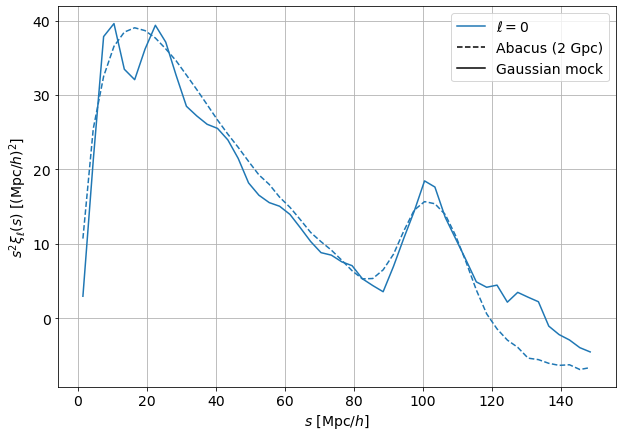

In [24]:
plt.rcParams["figure.figsize"] = (10, 7)

for ill, ell in enumerate(ells):
    plt.plot(s, s**2 * abacus_xiell[ill], linestyle = '--', color='C'+str(ill))
    plt.plot(s, s**2 * mocks_xiell[ill])
    # for legend
    plt.plot([],[], linestyle='-', color='C'+str(ill), label='$\ell = {:d}$'.format(ell))
    plt.grid(True)

plt.plot([],[], linestyle='--', color='black', label='Abacus (2 Gpc)')
plt.plot([],[], linestyle='-', color='black', label='Gaussian mock')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.legend()
plt.show()